# Elements for Stokes

Hello there!

Import some stuff

In [1]:
from dolfinx import cpp, fem, mesh

import ufl
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
import basix
import basix.ufl_wrapper

import matplotlib.pylab as plt

## Defining a Stokes solver

TODO: some text here, probably split this code into multiple cells.

In [2]:
def u_ex(x):
    sinx = ufl.sin(ufl.pi * x[0]) 
    siny = ufl.sin(ufl.pi * x[1])
    cosx = ufl.cos(ufl.pi * x[0])
    cosy = ufl.cos(ufl.pi * x[1])
    return 2*ufl.pi *sinx * siny * ufl.as_vector((cosy * sinx, - cosx * siny))

def p_ex(x):
    return ufl.sin(2*ufl.pi*x[0]) * ufl.sin(2*ufl.pi*x[1])

def source(x):
    u, p = u_ex(x), p_ex(x)
    return - ufl.div(ufl.grad(u)) + ufl.grad(p)



def solve_stokes(u_element, p_element, domain):
    V = fem.FunctionSpace(domain, u_element)
    Q = fem.FunctionSpace(domain, p_element)

    
    # Velocity boundary condition
    g = fem.Function(V)
    g.x.set(0.0)
    tdim = domain.topology.dim
    domain.topology.create_connectivity(tdim - 1, tdim)
    bdry_facets = mesh.exterior_facet_indices(domain.topology)
    dofs = fem.locate_dofs_topological(V, tdim - 1, bdry_facets)
    bcv = fem.dirichletbc(g, dofs)

    bcs = [bcv]

    # Define variational problem
    u, p = ufl.TrialFunction(V), ufl.TrialFunction(Q)
    v, q = ufl.TestFunction(V), ufl.TestFunction(Q)
    x = ufl.SpatialCoordinate(domain)
    f = source(x)
    a_matrix = [[ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx, ufl.inner(p, ufl.div(v)) * ufl.dx],
              [ufl.inner(ufl.div(u), q) * ufl.dx, None]]
    a = fem.form(a_matrix)
    L = fem.form([ufl.inner(f, v) * ufl.dx,  ufl.inner(fem.Constant(domain, PETSc.ScalarType(0)), q) * ufl.dx])

    # We will use a block-diagonal preconditioner to solve this problem:
    a_p11 = fem.form(ufl.inner(p, q) * ufl.dx)
    a_p = [[a[0][0], None],
           [None, a_p11]]

    # Assemble LHS matrix and RHS vector
    A = fem.petsc.assemble_matrix_nest(a, bcs=bcs)
    A.assemble()

    # We create a nested matrix `P` to use as the preconditioner. The
    # top-left block of `P` is shared with the top-left block of `A`. The
    # bottom-right diagonal entry is assembled from the form `a_p11`:

    P11 = fem.petsc.assemble_matrix(a_p11, [])
    P = PETSc.Mat().createNest([[A.getNestSubMatrix(0, 0), None], [None, P11]])
    P.assemble()
    b = fem.petsc.assemble_vector_nest(L)
    fem.petsc.apply_lifting_nest(b, a, bcs=bcs)

    # Sum contributions from ghost entries on the owner
    for b_sub in b.getNestSubVecs():
        b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    bcs0 = fem.bcs_by_block(fem.extract_function_spaces(L), bcs)
    fem.petsc.set_bc_nest(b, bcs0)

    # Create nullspace vector
    null_vec = fem.petsc.create_vector_nest(L)

    # Set velocity part to zero and the pressure part to a non-zero constant
    null_vecs = null_vec.getNestSubVecs()
    null_vecs[0].set(0.0), null_vecs[1].set(1.0)

    # Normalize the vector, create a nullspace object, and attach it to the
    # matrix
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    assert nsp.test(A)
    A.setNullSpace(nsp)
  
    # Now we create a Krylov Subspace Solver `ksp`. We configure it to use
    # the MINRES method, and a block-diagonal preconditioner using PETSc's
    # additive fieldsplit type preconditioner:

    # +
    ksp = PETSc.KSP().create(domain.comm)
    ksp.setOperators(A, P)
    ksp.setType("minres")
    ksp.setTolerances(rtol=1e-9)
    ksp.getPC().setType("fieldsplit")
    ksp.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)

    # Define the matrix blocks in the preconditioner with the velocity and
    # pressure matrix index sets
    nested_IS = P.getNestISs()
    ksp.getPC().setFieldSplitIS(
        ("u", nested_IS[0][0]),
        ("p", nested_IS[0][1]))

    # Set the preconditioners for each block
    ksp_u, ksp_p = ksp.getPC().getFieldSplitSubKSP()
    ksp_u.setType("preonly")
    ksp_u.getPC().setType("gamg")
    ksp_p.setType("preonly")
    ksp_p.getPC().setType("jacobi")
    ksp.setFromOptions()

    # Compute the solution
    u = fem.Function(V)
    p = fem.Function(Q)
    w = PETSc.Vec().createNest([u.vector, p.vector])
    ksp.solve(b, w)
    assert ksp.getConvergedReason() > 0
    u.x.scatter_forward()
    p.x.scatter_forward()

    # Error computation
    error_u = u - u_ex(x)
    H1_u = fem.form(ufl.inner(error_u, error_u) * ufl.dx + ufl.inner(ufl.grad(error_u), ufl.grad(error_u)) * ufl.dx)
    velocity_error = domain.comm.allreduce(np.sqrt(fem.assemble.assemble_scalar(H1_u)), op = MPI.SUM)
    error_p = -p - p_ex(x)

    L2_p = fem.form(error_p*error_p*ufl.dx)
    pressure_error = domain.comm.allreduce(np.sqrt(fem.assemble.assemble_scalar(L2_p)), op = MPI.SUM)
    print( ksp.getConvergedReason(), velocity_error, pressure_error)
    return velocity_error, pressure_error

TODO: some text here

In [3]:
def compute_errors(element_u, element_p, nmeshes=5):
    N0 = 10
    hs = np.zeros(nmeshes)
    u_errors = np.zeros(nmeshes)
    p_errors = np.zeros(nmeshes)
    for i in range(nmeshes):
        # This works
        # domain = mesh.create_rectangle(
        #    MPI.COMM_WORLD, [np.array([0, 0]), np.array([1, 1])],
        #    [N0*2**i, N0*2**i], mesh.CellType.triangle, mesh.GhostMode.none)
        # This doesn't work
        domain = mesh.create_rectangle(
            MPI.COMM_WORLD, [np.array([0, 0]), np.array([1, 1])],
            [N0, N0], mesh.CellType.triangle, mesh.GhostMode.none)
        for j in range(i):
            domain.topology.create_entities(1)
            domain = mesh.refine(domain)
        u_errors[i] , p_errors[i] = solve_stokes(element_u, element_p, domain)
        num_local_cells = domain.topology.index_map(domain.topology.dim).size_local
        hs[i] = np.max(cpp.mesh.h(domain, domain.topology.dim, np.arange(num_local_cells, dtype=np.int32)))
    return hs, u_errors, p_errors

## The elements

We now use the Stokes solver we have defined to experiment with a range of element pairs that can be used. First, we define a function that takes an element as input and plots a graph showing the error as $h$ is decreased.

In [4]:
%matplotlib inline

def error_plot(element_u, element_p, convergence=None, nmeshes=5):
    hs, v_errors, p_errors = compute_errors(element_u, element_p, nmeshes)

    legend = []
    if convergence is not None:
        y_value = 1.2 * v_errors[0]
        plt.plot([hs[0], hs[-1]], [y_value, y_value * (hs[-1] / hs[0])**convergence], "k--")
        legend.append(f"order {convergence}")
    print(hs, v_errors, p_errors)
    plt.plot(hs, v_errors, "bo-")
    plt.plot(hs, p_errors, "ro-")
    legend += ["velocity", "pressure"]
    plt.legend(legend)
    plt.xscale("log")
    plt.yscale("log")
    plt.axis("equal")
    plt.ylabel("Error in energy norm")
    plt.xlabel("$h$")
    plt.xlim(plt.xlim()[::-1])

## Piecewise constant pressure spaces

For our first element, we pair piecewise linear elements with piecewise constants. Using these elements, we do not converge to the solution.

2 14.089687140544413 116.57847206491417
2 2.3931484431608623 11.18167655094235
2 1.2838246339784884 12.383961556439877
2 0.6163484095528391 10.94745685019369
2 0.3768867708515607 11.021846051590966
[0.14142136 0.07071068 0.03535534 0.01767767 0.00883883] [14.08968714  2.39314844  1.28382463  0.61634841  0.37688677] [116.57847206  11.18167655  12.38396156  10.94745685  11.02184605]


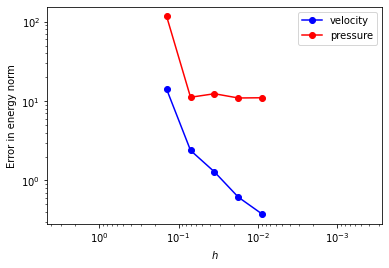

In [5]:
element_u = ufl.VectorElement("Lagrange", "triangle", 1)
element_p = ufl.FiniteElement("DG", "triangle", 0)
error_plot(element_u, element_p)

One way to obtain convergence with a piecewise constant pressure space is to use a piecewise quadratic space for the velocity (Fortin, 1972).

2 0.4121113245474692 0.10432907399812742
2 0.11041092611613444 0.054208663558809406
2 0.03576411646952679 0.026392117733299462
2 0.014429370880784153 0.013116725494011666
2 0.006706241388393503 0.006549173343514354
[0.14142136 0.07071068 0.03535534 0.01767767 0.00883883] [0.41211132 0.11041093 0.03576412 0.01442937 0.00670624] [0.10432907 0.05420866 0.02639212 0.01311673 0.00654917]


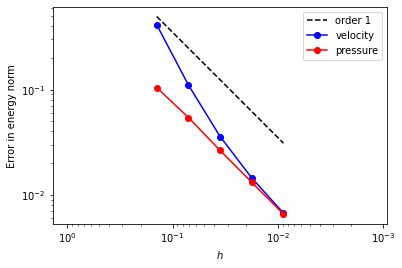

In [6]:
element_u = ufl.VectorElement("Lagrange", "triangle", 2)
element_p = ufl.FiniteElement("DG", "triangle", 0)
error_plot(element_u, element_p, 1)

Alternatively, the same order convergence can be achieved using fewer degrees of freedom if a Crouzeix-Raviart element is used for the velocity space (Crouziex, Raviart, 1973).

2 2.940354906253069 0.6586371682910992
2 1.4600505335388916 0.4224386316898796
2 0.7316635839837614 0.20998765829336496
2 0.3657534112771323 0.10591727853501025
2 0.1832026057305125 0.05179180183348196
[0.14142136 0.07071068 0.03535534 0.01767767 0.00883883] [2.94035491 1.46005053 0.73166358 0.36575341 0.18320261] [0.65863717 0.42243863 0.20998766 0.10591728 0.0517918 ]


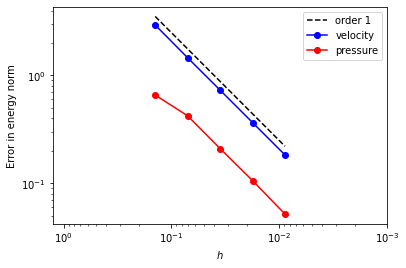

In [7]:
element_u = ufl.VectorElement("CR", "triangle", 1)
element_p = ufl.FiniteElement("DG", "triangle", 0)
error_plot(element_u, element_p, 1)

## Piecewise linear pressure space

When using a piecewise linear pressure space, we could again try using a velocity space one degree higher, but we would again observe that there is no convergence. In order to achieve convergence, we can augment the quadratic space with a cubic bubble function on the triangle (Crouziex, Falk, 1988).

2 0.6205725749843867 1.0512159620536956
2 0.12584501042521545 0.15436648492418786
2 0.03238440290627475 0.041730354638162485
2 0.008054053845537364 0.01014311914951187
2 0.002100854227973997 0.0029168746613385454
[0.14142136 0.07071068 0.03535534 0.01767767 0.00883883] [0.62057257 0.12584501 0.0323844  0.00805405 0.00210085] [1.05121596 0.15436648 0.04173035 0.01014312 0.00291687]


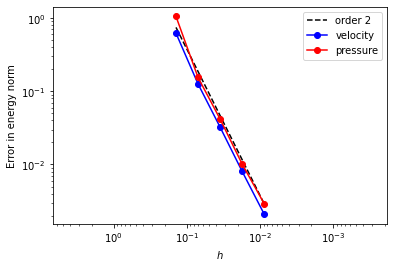

In [8]:
element_u = ufl.VectorElement(ufl.FiniteElement("Lagrange", "triangle", 2) + ufl.FiniteElement("Bubble", "triangle", 3))
element_p = ufl.FiniteElement("DG", "triangle", 1)
error_plot(element_u, element_p, 2)

## Piecewise quadratic pressure space

When using a piecewise quadratic space, we want to use a cubic velocity space. This cubic space must be augmented with quartic bubble functions. We have to define these bubble functions using a custom element, as the basis functions of a degree 3 Lagrange space and a degree 4 bubble space are not linearly independent: the custom element omits one of the bubbles (Crouzeix, Falk, 1988).

2 0.04245118979713626 0.05382399048565006
2 6.977748676176273 6.434619803220036
2 1.5507990724145944 1.6848917130696455
[0.14142136 0.07071068 0.03535534] [0.04245119 6.97774868 1.55079907] [0.05382399 6.4346198  1.68489171]


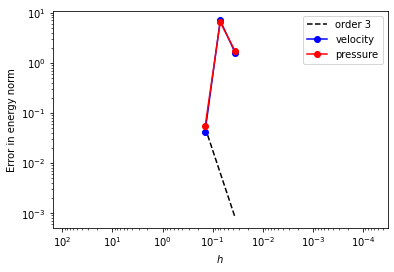

In [9]:
wcoeffs = np.zeros((9, 10))
pts, wts = basix.make_quadrature(basix.CellType.triangle, 6)
poly = basix.tabulate_polynomials(basix.PolynomialType.legendre, basix.CellType.triangle, 3, pts)
x = pts[:, 0]
y = pts[:, 1]
f = x * (1 - x) * y * (1 - y)
for j, f in enumerate([
    1, x, y, x**2*y, x*y**2, (1-x-y)**2*y, (1-x-y)*y**2, x**2*(1-x-y), x*(1-x-y)**2
]):
    for i in range(10):
        wcoeffs[j, i] = sum(f * poly[i, :] * wts)

x = [[], [], [], []]
x[0].append(np.array([[0.0, 0.0]]))
x[0].append(np.array([[1.0, 0.0]]))
x[0].append(np.array([[0.0, 1.0]]))
x[1].append(np.array([[2 / 3, 1 / 3], [1 / 3, 2 / 3]]))
x[1].append(np.array([[0.0, 1 / 3], [0.0, 2 / 3]]))
x[1].append(np.array([[1 / 3, 0.0], [2 / 3, 0.0]]))
x[2].append(np.zeros((0, 2)))

M = [[], [], [], []]
for _ in range(3):
    M[0].append(np.array([[[[1.]]]]))
for _ in range(3):
    M[1].append(np.array([[[[1.], [0.]]], [[[0.], [1.]]]]))
M[2].append(np.zeros((0, 1, 0, 1)))

p3_without_bubble = basix.ufl_wrapper.BasixElement(basix.create_custom_element(
    basix.CellType.triangle, [], wcoeffs, x, M, 0, basix.MapType.identity, False, 2, 3))
element_u = ufl.VectorElement(ufl.EnrichedElement(p3_without_bubble,ufl.FiniteElement("Bubble", "triangle", 4)))
element_p = ufl.FiniteElement("DG", "triangle", 2)
error_plot(element_u, element_p, 3, 3)

This last example is converging with the wrong order... (Crouzeix, Falk, 1988)

2 0.6451270809056044 0.7337816109803574
2 9.354760634391466 16.648275617927773
2 2.0311680504782483 2.682580744102708
[0.14142136 0.07071068 0.03535534] [0.64512708 9.35476063 2.03116805] [ 0.73378161 16.64827562  2.68258074]


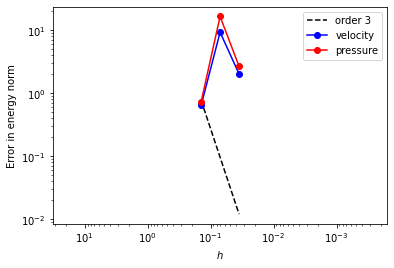

In [10]:
wcoeffs = np.eye(10)

x = [[], [], [], []]
for _ in range(3):
    x[0].append(np.zeros((0, 2)))
x[1].append(np.array([[1 - i, i] for i in [0.25, 0.5, 0.75]]))
x[1].append(np.array([[0.0, i] for i in [0.25, 0.5, 0.75]]))
x[1].append(np.array([[i, 0.0] for i in [0.25, 0.5, 0.75]]))
x[2].append(np.array([[1 / 3, 1 / 3]]))

M = [[], [], [], []]
for _ in range(3):
    M[0].append(np.zeros((0, 1, 0, 1)))
for _ in range(3):
    M[1].append(np.array([[[[1.], [0.], [0.]]], [[[0.], [1.], [0.]]], [[[0.], [0.], [1.]]]]))
M[2].append(np.array([[[[1.]]]]))

crouzeix_falk = basix.ufl_wrapper.BasixElement(basix.create_custom_element(
    basix.CellType.triangle, [], wcoeffs, x, M, 0, basix.MapType.identity, False, 3, 3))
element_u = ufl.VectorElement(crouzeix_falk)
element_p = ufl.FiniteElement("DG", "triangle", 2)
error_plot(element_u, element_p, 3, 3)

## References

Crouzeix, Michel and Falk, Richard S. Nonconforming finite elements for the Stokes problem, *Mathematics of Computation* 52, 437–456, 1989. [DOI: [10.2307/2008475](https://doi.org/10.2307/2008475)]

Crouzeix, Michel and Raviart, Pierre-Arnaud. Conforming and nonconforming finite element methods for solving the stationary Stokes equations, *Revue Française d'Automatique, Informatique et Recherche Opérationnelle* 3, 33–75, 1973. [DOI: [10.1051/m2an/197307R300331](https://doi.org/10.1051/m2an/197307R300331)]

Fortin, Michel. Calcul numérique des écoulements des fluides de Bingham et des fluides newtoniens incompressibles par la méthode des éléments finis (PhD thesis), Univ. Paris, 1972. 